In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Wine_Data/wine_data.xlsx')
df

,Unnamed: 0,image_path,file_name,Name,Brand,Type,Country
0,0,/content/drive/MyDrive/Wine_Data/Data/Specialt...,24998.json,Bask Rosé Wine Spritz,Bask,Specialty,Canada
1,1,/content/drive/MyDrive/Wine_Data/Data/Specialt...,408286.json,Lolea No 1 Red Sangria Spain,Lolea,Specialty,Spain
2,2,/content/drive/MyDrive/Wine_Data/Data/Specialt...,215343.json,Martini Rosso Vermouth,Martini & Rossi,Specialty,Italy
3,3,/content/drive/MyDrive/Wine_Data/Data/Specialt...,253914.json,Martini Dry Vermouth,Martini & Rossi,Specialty,Italy
4,4,/content/drive/MyDrive/Wine_Data/Data/Specialt...,44618.json,Colle Belvedere Frizzante,NaN,Specialty,Italy
...,...,...,...,...,...,...,...
5397,5397,/content/drive/MyDrive/Wine_Data/Data/Sparklin...,17193914.json,Sparkling Cuvée Brut,Oyster Bay,Sparkling,New Zealand
5398,5398,/content/drive/MyDrive/Wine_Data/Data/Sparklin...,17193910.json,Lightly Sparkling-Sauvignon Blanc,Villa Maria,Sparkling,New Zealand
5399,5399,/content/drive/MyDrive/Wine_Data/Data/Sparklin...,17195646.json,Special Reserve Brut Cuvée,Lindauer,Sparkling,New Zealand
5400,5400,/content/drive/MyDrive/Wine_Data/Data/Sparklin...,17180681.json,L'Ermitage Brut,Roederer Estate,Sparkling,United States


In [ ]:
df = df.dropna(subset=["image_path"])
df

,Unnamed: 0,image_path,file_name,Name,Brand,Type,Country
0,0,/content/drive/MyDrive/Wine_Data/Data/Specialt...,24998.json,Bask Rosé Wine Spritz,Bask,Specialty,Canada
1,1,/content/drive/MyDrive/Wine_Data/Data/Specialt...,408286.json,Lolea No 1 Red Sangria Spain,Lolea,Specialty,Spain
2,2,/content/drive/MyDrive/Wine_Data/Data/Specialt...,215343.json,Martini Rosso Vermouth,Martini & Rossi,Specialty,Italy
3,3,/content/drive/MyDrive/Wine_Data/Data/Specialt...,253914.json,Martini Dry Vermouth,Martini & Rossi,Specialty,Italy
4,4,/content/drive/MyDrive/Wine_Data/Data/Specialt...,44618.json,Colle Belvedere Frizzante,NaN,Specialty,Italy
...,...,...,...,...,...,...,...
5397,5397,/content/drive/MyDrive/Wine_Data/Data/Sparklin...,17193914.json,Sparkling Cuvée Brut,Oyster Bay,Sparkling,New Zealand
5398,5398,/content/drive/MyDrive/Wine_Data/Data/Sparklin...,17193910.json,Lightly Sparkling-Sauvignon Blanc,Villa Maria,Sparkling,New Zealand
5399,5399,/content/drive/MyDrive/Wine_Data/Data/Sparklin...,17195646.json,Special Reserve Brut Cuvée,Lindauer,Sparkling,New Zealand
5400,5400,/content/drive/MyDrive/Wine_Data/Data/Sparklin...,17180681.json,L'Ermitage Brut,Roederer Estate,Sparkling,United States


In [ ]:
class WineDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = sorted(df["Type"].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        label = self.class_to_idx[row["Type"]]

        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(128, scale=(0.8,1.0)),
    transforms.ToTensor(),

])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])


In [ ]:
# Train (70%), Val (15%), Test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["Type"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["Type"], random_state=42)

print(train_df.shape, val_df.shape, test_df.shape)

(3435, 7) (736, 7) (737, 7)


In [ ]:
train_dataset = WineDataset(train_df, transform=train_transform)
val_dataset   = WineDataset(val_df, transform=val_transform)
test_dataset  = WineDataset(test_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)

# Class weights for imbalance
class_counts = train_df["Type"].value_counts().sort_index().values
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0,0,0
    for x, y in tqdm(loader, desc="Training Batch"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = out.max(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss/len(loader), correct/total

In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0,0,0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    return total_loss/len(loader), correct/total, y_true, y_pred


In [ ]:
from tqdm.auto import tqdm

EPOCHS = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in tqdm(range(1, EPOCHS+1), desc="Epochs"):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1: Train Acc=0.247, Val Acc=0.136


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2: Train Acc=0.200, Val Acc=0.151


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3: Train Acc=0.211, Val Acc=0.166


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4: Train Acc=0.254, Val Acc=0.451


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5: Train Acc=0.291, Val Acc=0.307


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6: Train Acc=0.315, Val Acc=0.527


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7: Train Acc=0.368, Val Acc=0.395


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 8: Train Acc=0.441, Val Acc=0.276


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 9: Train Acc=0.443, Val Acc=0.455


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 10: Train Acc=0.467, Val Acc=0.450


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 11: Train Acc=0.480, Val Acc=0.514


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 12: Train Acc=0.487, Val Acc=0.466


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 13: Train Acc=0.516, Val Acc=0.410


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 14: Train Acc=0.529, Val Acc=0.489


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 15: Train Acc=0.502, Val Acc=0.560


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 16: Train Acc=0.518, Val Acc=0.496


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 17: Train Acc=0.544, Val Acc=0.321


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 18: Train Acc=0.543, Val Acc=0.474


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 19: Train Acc=0.554, Val Acc=0.542


Training Batch:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 20: Train Acc=0.551, Val Acc=0.560


In [ ]:
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)

print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.573


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

Classification Report:
                precision    recall  f1-score   support

     Champagne       0.29      0.79      0.42        24
       Dessert       0.20      0.19      0.19        16
     Fortified       0.17      0.64      0.26        25
       Icewine       0.14      0.71      0.23         7
           Red       0.94      0.56      0.70       273
          Rose       0.71      0.82      0.76        61
Sake_Rice_wine       0.47      0.45      0.46        51
     Sparkling       0.48      0.35      0.40        81
     Specialty       0.18      0.24      0.20        21
         White       0.77      0.67      0.72       178

      accuracy                           0.57       737
     macro avg       0.43      0.54      0.44       737
  weighted avg       0.70      0.57      0.61       737



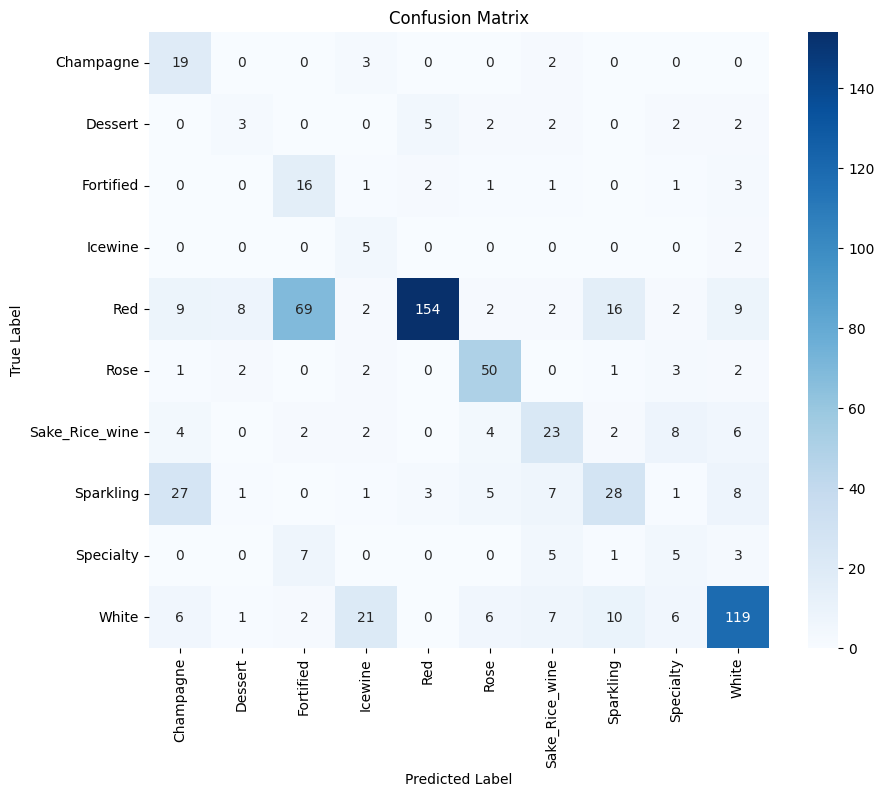

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()